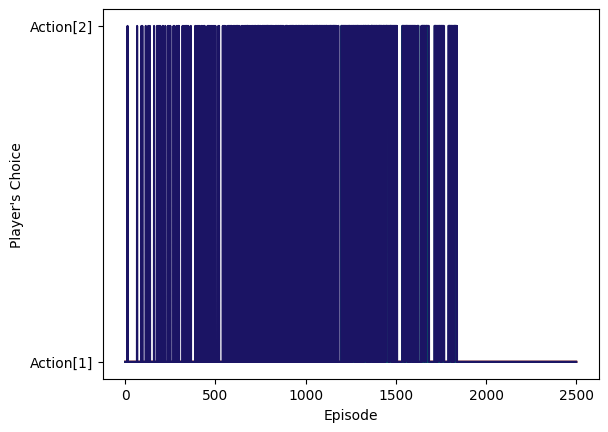

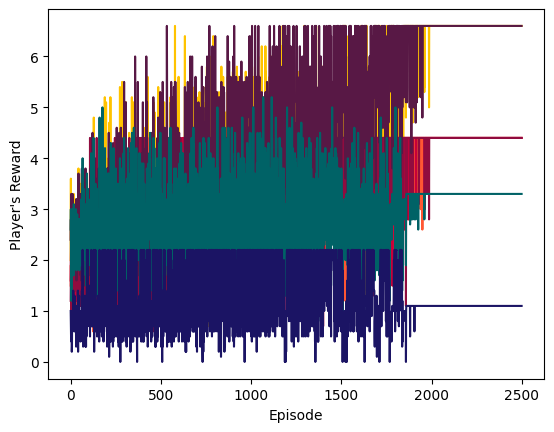

Player[0]: (action: Action[1], q-table: {'Action[1]': 19.51, 'Action[2]': 17.84})
Player[1]: (action: Action[1], q-table: {'Action[1]': 19.51, 'Action[2]': 18.0})
Player[2]: (action: Action[1], q-table: {'Action[1]': 19.51, 'Action[2]': 18.0})
Player[3]: (action: Action[1], q-table: {'Action[1]': 19.51, 'Action[2]': 17.97})
Player[4]: (action: Action[1], q-table: {'Action[1]': 19.51, 'Action[2]': 17.59})
Player[5]: (action: Action[1], q-table: {'Action[1]': 9.51, 'Action[2]': 9.02})
Player[6]: (action: Action[1], q-table: {'Action[1]': 10.11, 'Action[2]': 9.78})


In [1]:
import time
import random
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

# Iterative Coordination Game
actions = ["Action[1]", "Action[2]"]
types = ['X', 'X', 'X', 'X', 'X', 'Y', 'Y']
payoff = {"X": [[2,0],[0,1]], "Y": [[1,0],[0,2]]}
neighbors = [[0,4],[0,5],[0,3],[1,2],[1,4],[2,3],[4,5],[5,6]]
frequencies = [sum(num in sublist for sublist in neighbors) for num in range(max(max(sublist) for sublist in neighbors) + 1)]

def game_print(phase, ep, maxep, players_data):

    if phase == "exploration" and ep % int(maxep/10) == 0:
        print("\nRound.{} - Exploration ".format(ep) + "*"*55)
        for p in range(len(players_data)):
            print(players_data[p]["name"] + ": (action: " + players_data[p]["action"] + ", q-table: " + str(players_data[p].get("qtable")) + ")")
        time.sleep(0)

    elif phase == "exploitation" and (ep % int(maxep/10) == 0 or (ep >= maxep-10 and ep <= maxep)):
        print("\nRound.{} - Exploitation ".format(ep) + "*"*55)
        for p in range(len(players_data)):
            print(players_data[p]["name"] + ": (action: " + players_data[p]["action"] + ", q-table: " + str(players_data[p].get("qtable")) + ")")
        time.sleep(0)

def graph(x_max, y_ranges, x_label, y_label):
    c = 0
    colours = ['#FFC300', '#FF5733', '#C70039', '#900C3F', '#581845', '#006266', '#1B1464']
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    x = [x_value for x_value in range(x_max)]
    if y_label == "Player's Choice":
        y_values = [actions[0], actions[1]]
        plt.yticks(np.arange(0, 2, 1), y_values)
    for y in y_ranges:
        plt.plot(x, y, color=colours[c])
        c += 1
    plt.show()

def action_to_id(action):
    if action == actions[0]:
        id = 0
    elif action == actions[1]:
        id = 1
    return id

def qlearning(players_data):
    moments = 10
    episodes = 2500
    ep = 0
    alpha = 0.1
    gamma = 0.9
    epsilon = 1.0
    decay = 0.01
    accuracy = 10

    rwXep = [[0 for e in range(episodes)] for p in range(len(players_data))]
    acXep = [[0 for e in range(episodes)] for p in range(len(players_data))]

    while ep < episodes: 
        for pair in neighbors:  # n = [0,4], ...
            m = 0
            choice = round(random.uniform(0, 1), accuracy)
            while m <= moments:
                m += 1
                if choice < epsilon : # EXPLORATION
                    players_data = explore(pair, players_data)
                    acXep, rwXep, players_data = update(pair, players_data, alpha, gamma, acXep, rwXep, ep, moments)
                    #game_print("exploration", ep, episodes, players_data)
                else: # EXPLOITATION
                    players_data = exploit(pair, players_data)
                    acXep, rwXep, players_data = update(pair, players_data, alpha, gamma, acXep, rwXep, ep, moments)
                    #game_print("exploitation", ep, episodes, players_data)
        ep = ep + 1
        if epsilon > 0.000000:
            epsilon -= decay/20  # X=20
        else:
            epsilon = 0.000000

    x_axis = "Episode"
    y_axis = "Player's Choice"
    acXep = [[int(num) for num in sublist] for sublist in acXep]
    graph(episodes, acXep, x_axis, y_axis)
    y_axis = "Player's Reward"
    graph(episodes, rwXep, x_axis, y_axis)

def update(pair, players_data, alpha, gamma, acXep, rwXep, ep, moments):
    for p in pair:
        player_action = players_data[p].get("action")
        opponent_action = players_data[get_opponent(p, pair)].get("action")
        oldQ = players_data[p].get("qtable")[player_action]
        reward = players_data[p]["payoff"][action_to_id(player_action)][action_to_id(opponent_action)]
        maxQ = max(players_data[p]["qtable"].values())
        newQ = round((1-alpha)*oldQ + alpha*(reward + gamma*maxQ), 2)
        players_data[p].get("qtable")[player_action] = newQ
        rwXep[p][ep] += reward/moments
        acXep[p][ep] += action_to_id(player_action)/(moments*frequencies[p])   # this value will finally
        # be something like e.x: 0.8 indicating that this player chose Action-2 (8) times in this current episode
    return acXep, rwXep, players_data

def get_opponent(player, pair):
    opponent = pair[0] if player == pair[1] else pair[1]
    return opponent

def explore(pair, players_data):
    for p in pair:  # [0,4]
        random_action = random.choice([actions[0], actions[1]])
        players_data[p]["action"] = random_action
    return players_data

def exploit(pair, players_data):
    for p in pair:
        optimal_action = max(players_data[p]["qtable"], key=players_data[p]["qtable"].get)
        players_data[p]["action"] = optimal_action
    return players_data

def main():
    num_players = 7
    players_data = []
    
    for p in range(num_players):
        players_data.append({
            "name": "Player[{}]".format(p),
            "type": types[p],
            "action": None,
            "payoff": payoff[types[p]],
            "qtable": {actions[0]: 0, actions[1]: 0}
            })

    qlearning(players_data)

    for p in range(num_players):
        print(players_data[p]["name"] + ": (action: " + players_data[p]["action"] + ", q-table: " + str(players_data[p].get("qtable")) + ")")
       
if __name__ == "__main__":
    main()